Class distribution after SMOTE: {np.int64(0): np.int64(900), np.int64(1): np.int64(900), np.int64(2): np.int64(900)}
Stacking Model Accuracy: 92.41%

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88       180
           1       0.85      0.93      0.89       180
           2       1.00      1.00      1.00       180

    accuracy                           0.92       540
   macro avg       0.93      0.92      0.92       540
weighted avg       0.93      0.92      0.92       540


Confusion Matrix:
 [[151  29   0]
 [ 12 168   0]
 [  0   0 180]]


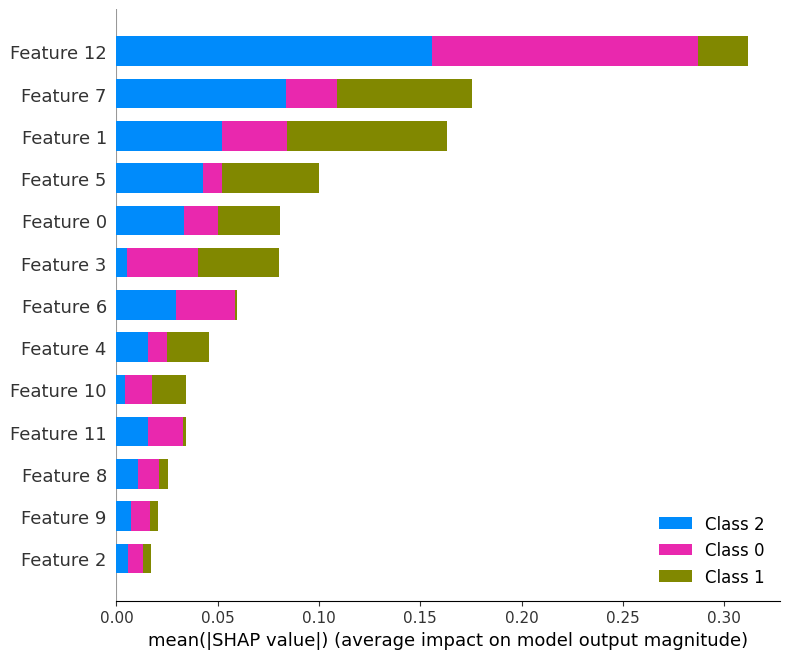

Stacking model and scaler saved successfully!


In [3]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

# Load real dataset
real_data = pd.read_csv("real_cancer_data.csv")

# Drop non-informative columns
real_data = real_data.drop(columns=['Patient_ID', 'Sample_ID', 'Survival_Status'], errors='ignore')

# Identify categorical and numerical features
categorical_features = real_data.select_dtypes(include=['object']).columns
numerical_features = real_data.select_dtypes(exclude=['object']).columns

# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    real_data[col] = le.fit_transform(real_data[col].astype(str))
    label_encoders[col] = le

# Assume last column is target, rest are features
X_real = real_data.iloc[:, :-1]
y_real = real_data.iloc[:, -1]

# Impute missing values only in numerical columns
X_real[numerical_features] = X_real[numerical_features].apply(pd.to_numeric, errors='coerce')
X_real[numerical_features] = X_real[numerical_features].fillna(X_real[numerical_features].median())

# Adjust informative and redundant features dynamically
n_features = X_real.shape[1]
n_informative = max(10, int(n_features * 0.7))  # 70% informative features
n_redundant = max(2, int(n_features * 0.2))  # 20% redundant features

# Generate synthetic data
X_synth, y_synth = make_classification(n_samples=1000, n_features=n_features, n_informative=n_informative,
                                       n_redundant=n_redundant, n_clusters_per_class=2, weights=[0.5, 0.5],
                                       random_state=42)

# Convert to DataFrame for consistency
df_synth = pd.DataFrame(X_synth, columns=X_real.columns)
df_synth["Cancer Type Detailed"] = y_synth

# Combine real and synthetic datasets
df_combined = pd.concat([real_data, df_synth], ignore_index=True)

# Define features and target
X = df_combined.drop(columns=["Cancer Type Detailed"], errors='ignore')
y = df_combined["Cancer Type Detailed"]

# Ensure target variable is numeric
y = LabelEncoder().fit_transform(y)

# Handle missing values in features
X = X.apply(pd.to_numeric, errors='coerce').fillna(X.median())

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution after SMOTE:", dict(zip(unique, counts)))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning for RandomForest
rf_params = {'n_estimators': [10, 20], 'max_depth': [2, 3], 'min_samples_split': [5, 10]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Hyperparameter tuning for GradientBoosting
gb_params = {'n_estimators': [10, 20], 'learning_rate': [0.01, 0.03], 'max_depth': [1, 2]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='accuracy')
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_

# Hyperparameter tuning for SVM
svm_params = {'C': [0.03, 0.05, 0.1]}
svm_grid = GridSearchCV(SVC(probability=True, kernel='rbf', random_state=42), svm_params, cv=3, scoring='accuracy')
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

# Define base models with best parameters
base_models = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('svm', best_svm)
]

# Meta-model
meta_model = LogisticRegression(max_iter=200)

# Stacking Classifier
stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=3)
stack_model.fit(X_train, y_train)

# Model evaluation
y_pred = stack_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# SHAP Explanation using Random Forest (or Gradient Boosting)
explainer = shap.Explainer(best_rf, X_train)  # or best_gb
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# Save the model
joblib.dump(stack_model, "stacked_cancer_detection_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Stacking model and scaler saved successfully!")
